# Build your own machine-learning agent

### Implement a reinforcement-learning algorithm with no coding experience required 

---

> What is machine-learning?


With an increased focus on analytics technologies across countless industries in recent years, and phrases like "data is the new oil" abounding, the topics of big data and machine-learning are increasingly difficult to avoid in conversations with anybody from a close friend to a passing stranger. But how many of us really know what data science or artificial intelligence can do?

If effective regulations take hold in these industries it will be because the global population of users comes to appreciate their power and demands a say in their governance, not because the engineers at Facebook grow a conscience. While any specialized field would take decades to master there are some fundumantal concepts in data science that non-coders can and should try to grasp. 

This tutorial is designed to demonstrate how a simple machine-learning algorithm works by allowing you to build one yourself—without any experience in coding or mathematics required. If you are a practicing data scientist and want to build your own agent, [go here](https://github.com/js-fitz/Q-Learning/) to switch to the technical version of this notebook, where you'll write all the functions for yourself.


## Q-Learning Tic-Tac-Toe 


Today you'll learn the concepts underlying a **Q-Learning** algorithm by creating and training a computer "agent" to become a killer tic-tac-toe player. All the functions are pre-written, so you just need to run each code block as-is. In case this is your first time in Jupyter: sections of text with a gray background contain the commands we'll send to our computer. To "run" the code, click anywhere inside the block, then type `shift-enter`. You will know the code has run succesfully when the `[ ]` at the top-left of the block fills with a number. If you recieve an error message at any point, refresh this page to restart the kernel—just be sure to **re-run the initial code block (below) each time you refresh to import the required functions**.

You should run every code block (section of text with a gray background) in this notebook to enjoy the full article. The first block you need to run imports the `ql_functions` module, containing all the back-end code for the functions used to create an environment, create an agent, train the agent, and eventually to play against it in an interactive session. Click the following code block and type `shift-enter`.

In [2]:
%matplotlib notebook
# enable animations

from ql_functions import *

Remember to re-run the above cell if you refresh the page/restart the kernel. With `ql_functions` imported, you can now call any and all of our pre-made functions from inside this notebook. For example, you can call the `new_board` function to create a fresh environment, a blank board with no tiles on it. To display the board, you can pass the output from `new_board` to the `show` function as an argument:

In [ ]:
my_board = new_board()

show(my_board)

Congratulations! You just ran your first two functions, `new_board` and `show`. You also created an object representing a blank board, `my_board`. On the backend, when you call or run a function in this notebook, the server uses code from a file called `ql_functions` to execute the operation. I pre-wrote all the necessary functions and saved them in `ql_functions` so you can focus on the high-level process taking place in reinforcement learning without getting bogged down by technical details. If you hit an error, just scroll back and re-import the module by running the first code block again.

### Q-Learning Overview

Q-Learning, a branch of reinforcement-learning, is a technique for teaching a computer agent how to respond to different states of an environment by simulating many actions and evaluating their various outcomes. To start, our agent will move randomly throughout a game. At the end of every match, a process called **backpropagation** then assigns rewards to moves by the winning player and penalties to moves made by the losing player. By simulating thousands of games, we will build a reference dictionary of all the best moves to make from every possible state of the environment—effectively compiling a decision-making guide for the agent.

## 1. Setting up the environment

We think of tic-tac-toe in terms of rows and columns, but for our agent it's easier to refer to the board as a list of position indexes from 1-9. The `new_board` function generates a list object, which is how the agent "sees" a blank board (with unoccupied positions represented by spaces).

In [ ]:
my_board = new_board()

''.join(my_board)

The `new_board()` function creates a "fresh" environment, so right now our board is empty, a nine character–long list containing only spaces.

#### 1.2 The `show` function

The `show` function takes a `board` argument and prints it in a more familiar format. It also accepts an argument called `helpers`, which if `True` will show optional position indexes on open tiles (for humans to select a move).

Call the `show` on the board you created above with `helpers=True` to see labels on the empty board positions—run the following cell:

In [ ]:
show(my_board,
     helpers=True)

#### 1.3 The `evaluate` function

Next we need a function to evaluate a given board state. It should always return one of a few possible outcomes: a `Win`, a `Tie`, or `Continue` (empty spaces remaining). Below, test the `evaluate` function using three different states, showing each board and then printing the result of calling `evaluate`. 

In [ ]:
test_boards = ["         ",
               "X O XO OX",  # you can edit any of these
               "OXOXXOXOX" ] # just make sure they're 9 characters long! 

In [ ]:
print('Testing the evaluator function:\n')

for board in test_boards:
    show(board)
    print('evaluator says:', evaluate(board), '\n')

If empty spaces remain and neither player has won, `evaluate` returns `Continue`, triggering the next move. In the examples above, you also saw how `show` assigns a color to each player — this is for our sake, not the computer's.

With our environment established, it's time to build the agent.


## 2. Making a move

How does a computer-driven agent "decide" where to move? In our case, the answer lies in a **Q Table**: a dictionary for storing thousands of possible board states along with the rewards of the possible moves (actions) from each state. By taking the action with the **highest Q value** at every step in a game, a fully-trained agent can develop general strategies for winning without memorizing specific paths to victory.


#### 2.1 Agent Perception

We want an agent who can play both as X (going first) and as O (going second), so we need to train for both. This effectively means we need to store every state twice, with a set of Q values from each player's perspective. Instead of maintaining a separate Q table for each player, by flipping the tiles for half the process we let the agent see itself as X all the time. We'll use the `flip_board` function any time we reference the Q Table from O's perspective. Run the following for an example:

In [ ]:
my_board = 'X  OOO XX'
flip_board(my_board)

Every time the agent sees a new board state, it will add it to the Q Table and initialize the rewards for all the possible moves from that state at a default initial value. We use a relatively high initial Q of `0.3` for a strategy called **optimistic learning**, encouraging the agent to try out unknown moves. 

#### 2.2 The Exploration-Exploitation Trade-Off

One challenge in reinforcement learning comes in finding a balance between **exploration** and **exploitation**. Avery Parkinson illustrates with this analogy:

> Let’s say that you and your friends are trying to decide where to eat. In the past, you’ve always gone to a Mexican restaurant around the corner, and you’ve all really enjoyed it. However, this time, one of your friends mentions that a new Lebanese place has opened up down the street, and it’s supposed to be really good. None of you guys can come to a consensus — should you go to the Mexican restaurant which you know to be really good, or should you try the Lebanese place which has the potential to be better or worse? ([source](https://medium.com/analytics-vidhya/the-epsilon-greedy-algorithm-for-reinforcement-learning-5fe6f96dc870))

Similarly, our agent needs to decide throughout a simulation whether to explore new moves through random selection or to exploit prior information by choosing the move with the highest Q. We pursue this balance over many simulated decisions in Q-Learning using an **epsilon-greedy algorithm**. With epsilon (**ε**) set to 1, the agent moves randomly (exploring), while sliding **ε** towards zero triggers more moves based on existing knowledge (exploiting).

#### 2.3 The ε-Greedy Move Function


By setting epsilon to shrink over time, we let the agent rely more heavily on the Q Table towards the end of a simulation while taking more exploratory (random) moves early on. This effect is demonstrated below over 100 iterations. How does the ε-greedy algorithm help the agent change strategies over time?

In [ ]:
e_init = 0.7     # how much to explore at the start (1 => all exploration)
e_terminal = 0   # how much to exploit at the end   (0 => all exploitation)

_=simulate_e_greedy(e_init, e_terminal)

As you can see, shrinking the epsilon value over time allows more exploration early on while increasing the agent's confidence to make more informed decisions near the end. The agent uses a function called `get_move` to apply this formula. Below is an example of calling `get_move` on a blank board with a forced-random decision (ε=1), which we'll use for now because our agent still has no prior information for basing its decisions

In [ ]:
get_move(new_board(), epsilon=1)

Run the above code again to see the agent pick random moves on an empty board. You can re-run any cell in this notebook using `shift-enter` as many times as you want. From hereon out, all the functions have at least some randomness built in, so running a cell multiple times may produce different results.

## 3. Simulations and Backpropagation

#### 3.1 Match simulator

To populate the Q Table with more accurate estimates of the quality of different moves, we first need to simulate an entire game. This function will drive our training sessions. The `simulate_game` function starts by calling `new_board` to make a fresh environment, then switches back and forth between players (always starting with `X`) calling `get_move` for each player until the `evaluate` function registers a win or a tie (a terminal state).

We can set unique **ε**-values for each player's epsilon-greedy `get_move` decision within `simulate_game` using the `epsilon_x` and `epsilon_o` arguments. As the agent collects more information over time, we will shrink these values to encourage more reliance on the Q Table for move decisions. For now, we leave both players' epsilon values at 1, so the game you're about to watch is totally random.

In [ ]:
simulate_game( epsilon_x = 1 ,
               epsilon_o = 1 ,
               slow_down = 5 ) # increase this to slow down

The `simulate_game` function builds a crucial history object called `steps` (seen above in the function's post-game output) with the entire sequence of moves in a game. Each move is associated with the decision space from which it was chosen (the state of the board just before the action). Using this brief "memory", we will now go back to small adjustments, reflecting rewards and penalties for players' moves depending on the game winner.

#### 3.2 Updating Q-Values

Take a look at the following diagram to review the Q-Learning process:

In [ ]:
ql_flow()

The size of the reward or penalty assigned to each move in backpropagation depends on a few factors. For example, the later a move is made in a game, the larger the affect it has on the Q Table. Moves leading to a tie are also penalized, but less than those leading to a loss. You can find the entire Q value–update formula in the [technical version](https://github.com/js-fitz/Q-Learning/) of this notebook, but for now, just know that **previous learning affects how the agent acquires new knowledge**.

#### 3.3. Backpropagation

At the end of every game, we feed the history of `steps` in the match to a function called `backpropagate`, which will make slight adjustments to the values in the Q table corresponding to each move. For the winning player, moves receive a reward, and for the losing player, `backpropagate` assigns a penalty. Run the function with the `wait_seconds` argument to show each adjustment:

In [ ]:
# first simulate a quick game
steps, winner = simulate_game(slow_down=2)

# then backpropagate over the steps of the game
backpropagate(steps, winner, wait_seconds=2.5) # <- increase wait_seconds to slow down

Every step in backpropagation incorporates a key variable called `max_future_q`, representing the reward value of the best possible move from future states given the current action. Accounting for potential future rewards to rate the quality of a given action drives the agent to optimize long-term reward.

## 4. Training

Time to bring it all together. With the code above, you backpropagated through all the steps in a game. Below, we simulate hundreds of games, focusing throughout on a few select board states. The `visualize_learning` function calls `simulate_game` repeatedly and runs `backpropagate` over all the `steps`, continuously updating the Q Table after every game. Here you can also watch the Q values for the action space of a given state develop over time.

#### 4.1 Hyperparameter Tuning

We run three types of games: one for each player (X and O) to compete against a random opponent, and a third where both players try to win. In addition to the winning rates of each player over time, a dashed blue lines plots the shrinking epsilon level for the player(s) being trained. As this line drops, the training player will make a larger percentage of its moves "intelligently" by referring to the Q Table (increasing exploitation), so its winning rate should go up. To stop the training and the animation early, click the power button at the top of the plot.

Launching simulator... done.
Launching animation...

<IPython.core.display.Javascript object>


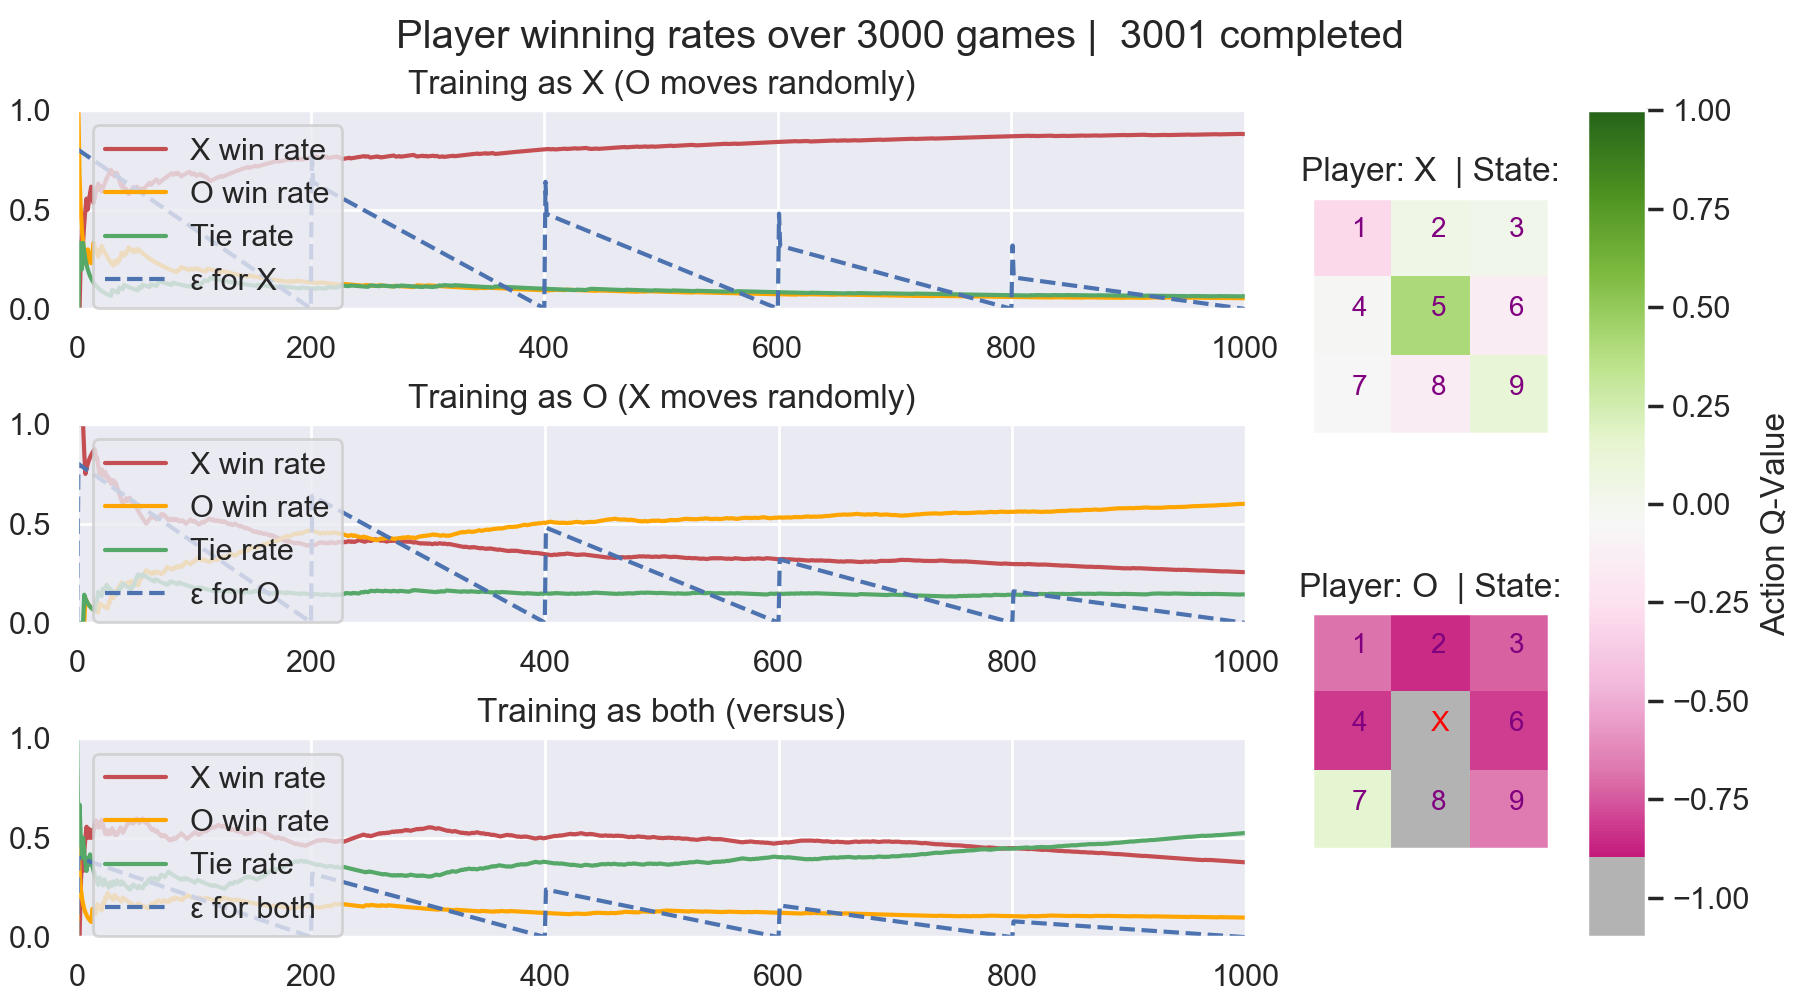

In [4]:
anim=visualize_learning(lrate=.1,             # how quickly new values replace old values
                     discount=.9,          # how important are future rewards 
                     init_e=.8,            # maximum epsilon value
                     batches=5,           # number of times to shrink epsilon
                     sims_per_batch=200,   # games per batch, per game type (3)
                     boards=['         ',  # watch Q val heatmap for X's first move
                             '    X    ']) # watch Q val heatmap for O's response 


The Q Tables to the right depict the estimated rewards for moves from two select states. The first heatmap represents X's response to a blank board, showing how the agent develops a strong opening move. An empty board is the only state guaranteed to appear in every game, so we know it will recieve an update every time we `backpropagate`. We also include a heatmap for `'    X    '`, representing how O learns to respond if X starts in the middle.

Depending on which opening move X learns to favor (the darkest green square on the upper heatmap), you may wish to alter the second `board` argument in `visualize_learning` to see how O develops its response. For instance, if the X agent gives position 1 the highest Q value, change the second board to `'X         '`. You can observe any board state with the function above, but keep in mind that the further you go into a game (with more tiles on the board), the more obscure the state will be so the less often its Q values will recieve an update.


#### 4.2 More Practice

So far, the agent performs adequately: X has quickly learned to capitalize on its status as the first player, but O still struggles to avoid defeat even when playing against a random opponent. In the third game type of the above training session, the agent assumed both roles, so the proportion of ties should increase. This initial simulation lets us evaluate how different **hyperparameters** control the training process—listed above as arguments passed to the `visualize_learning` function. Feel free to play with these values and re-run the simulation to see how they affect learning.

Run the following code to bring your agent from novice to master. We save the plotting for the end this time to speed up the process:

In [ ]:
full_training()

Math tells us there are [4,520](https://math.stackexchange.com/questions/3276315/number-of-uncompleted-tic-tac-toe-games) total possible incomplete states on a 3x3 tic-tac-toe board, i.e. states we want our agent to learn about. With over 45,000 games under its belt, check the length of your Q Table to see how many of these states your agent has seen:

In [ ]:
print(f'The agent has encountered {round(100*len(q_table)/4520, 2)}% of all possible board states on a 3x3 board')

To see this number hit 100, run `full_training` once more.

## Testing

This final function is for you to play against the agent. With epsilon set to zero, all of the agent's moves are now determined by the Q Table. After sufficiently training your agent, give it your best shot—playing as `X` or `O`, can you outsmart the Q Table? Run the following cell then type `enter` after responding to each prompt. To restart, you can enter `q` as your move.

In [ ]:
versus_agent()

---
# Bonus

### Increasing environment complexity with a bigger board

Use the following function to change the size of the board. Try setting the `size` to `4` while leaving the minimum winning length (`min_contig`) at `3` — if you play for a four-in-a-row win on a 4x4 board, eventually every game will end in a tie! We train over more batches this time to allow the agent to adapt to the more complex environment, so sit back and relax for a minute. Then try playing as O against your agent — you will lose every match.

In [ ]:
game_settings( size=4 ,
               min_contig=3 )
show(new_board())

In [ ]:
full_training(batches=25) # may take a few minutes, but you can increase for more training

In [ ]:
# wait for training to finish before running:
versus_agent()